In [1]:
import numpy as np
from matplotlib import pyplot, cm
%matplotlib inline

from tqdm import tqdm
import time

import sys
np.set_printoptions(threshold=sys.maxsize)

# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [2]:
g0=4     #Bacterial growth Parameter
gamma=16     #Bacterial growth Parameter
k_value=42.5     #Bacterial growth Parameter

Dc=1e-3
Db=.21

t_ref=20
Xe_value=.3

X0=1e-3

C0=15
C_thresh_value=1.5

d=20 #separation between inoculum change; check for 5mm, 10mm, 20mm
rho=2.5
mu=40

dx=dy = 0.25

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))


Current time is: Sun Nov  3 10:54:36 2019


In [3]:
X1=np.zeros((369,369),dtype=np.float64)   # 2-D array 
X2=np.zeros((369,369),dtype=np.float64)
C=np.zeros((369,369),dtype=np.float64)
m=np.zeros((369,369))
Xe=np.zeros((369,369))
C_thresh=np.zeros((369,369))
k=np.zeros((369,369))

#(taking x,y for coordinate positions) :
x=np.linspace(-184,184,num=369,dtype=int)
y=np.linspace(-184,184,num=369,dtype=int)
 
############# Defining Initial Conditions #############
# for X1 and X2
for i in range(len(x)):
    for j in range(len(y)):
        if  ((x[i]-d/2)**2 + y[j]**2 <= rho**2):
            X1[i,j] = X0
        
        if  (x[i]+d/2)**2 + y[j]**2 <= rho**2:
            X2[i,j] = X0


                                                                       #np.savetxt('output.txt',X1,fmt='%.4e')

#Initializing parameters in array for all positional coordinates on 2D grid:
for i in range(len(x)):
    for j in range(len(y)):
        C[i,j]=C0
        C_thresh[i,j]=C_thresh_value
        Xe[i,j]=Xe_value
        k[i,j]=k_value

X1_hist=[]
X2_hist=[]
C_hist=[]

X1_hist=[X1.copy()]
X2_hist=[X2.copy()]
C_hist=[C.copy()]

print("Initializing Initial Conditions has been completed")
#######################################################        
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

Initializing Initial Conditions has been completed
Current time is: Sun Nov  3 10:54:38 2019


In [4]:
def H_t(var,value):        # heavy side step function for time, not for matrix output
    if var-value <0:
        return 0
    if var-value==0:
        return 0.5
    else: return 1

    
def H_pos(mat1,mat2):      # heavy side step function for position, for matrix output H(Xe,X1+X2)
    
    mat3=np.zeros((max(mat1.shape),min(mat1.shape)))
    for i in range(max(mat1.shape)):
        for j in range(min(mat1.shape)):
            if mat1[i,j]-mat2[i,j]<0:
                mat3[i,j]=0
            if mat1[i,j]-mat2[i,j]==0:
                mat3[i,j]=0.5
            else: mat3[i,j]=1
  
    return mat3
       

def growth(nt,time_length):  # to be given number of time steps
    
    # nt : number of time-steps -- to be made 5001
    # time_length in hours: duration of time upto which you wish to see the simulation --- to be made 48 hours

    dt=time_length/nt       # time-step size
    print("The growth for time by time step %f has been completed for:-" %dt)
    
    for n in range(nt):
        
        g_c=g0*np.divide(C,np.add(k,C))
        
        m[:,:]=mu*np.multiply(np.multiply(X1[:,:],X2[:,:]),H_pos(Xe,X1+X2))*H_t((n-1)*dt,t_ref)
        X1[1:-1,1:-1]=X1[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X1[1:-1,1:-1]))+Db*np.multiply(H_pos(C[1:-1,1:-1],C_thresh[1:-1,1:-1]),(((X1[2:,1:-1]-2*X1[1:-1,1:-1]+X1[:-2,1:-1])/dx**2) + ((X1[1:-1,2:]-2*X1[1:-1,1:-1]+X1[1:-1,:-2])/dy**2))) - m[1:-1,1:-1])
        X2[1:-1,1:-1]=X2[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X2[1:-1,1:-1]))+Db*np.multiply(H_pos(C[1:-1,1:-1],C_thresh[1:-1,1:-1]),(((X2[2:,1:-1]-2*X2[1:-1,1:-1]+X2[:-2,1:-1])/dx**2) + ((X2[1:-1,2:]-2*X2[1:-1,1:-1]+X2[1:-1,:-2])/dy**2))) - m[1:-1,1:-1])
        
        C[1:-1,1:-1]= C[1:-1,1:-1] +dt*(-gamma*(np.multiply(g_c[1:-1,1:-1],np.add(X1[1:-1,1:-1],X2[1:-1,1:-1]))) + Dc*(((C[2:,1:-1]-2*C[1:-1,1:-1]+C[:-2,1:-1])/dx**2) + ((C[1:-1,2:]-2*C[1:-1,1:-1]+C[1:-1,:-2])/dy**2)))

        ############# Start: Boundary Conditions ######################
        
        #Neumann Condition: Normal component of Bacterial density on boundary is zero
        
        X1[:][-1] = X1[:][-2]
        X1[:][0]  = X1[:][1] 
        X1[-1][:] = X1[-2][:]
        X1[0][:]  = X1[1][:] 

        
                            # not sure whether it is a right way of doing. Perhaps, it should be opposite way as above calculation stencil never go on edge, so it would remain X0 eternally. But, it should change
        X2[:][-1] = X2[:][-2]
        X2[:][0]  = X2[:][1] 
        X2[-1][:] = X2[-2][:]
        X2[0][:]  = X2[1][:] 

        
        
        #Dirichlet condition: Fixed and Unchanging Concentration of growth media on boundary
        C[0][:]=C[-1][:]=C[:][0]=C[:][-1]=C0
        
        ############# End: Boundary Conditions ######################

        ############ Start: Saving history of Bacterial Density and Growth Media Concentration #########
        
        X1_hist.append(X1)
        X2_hist.append(X2)
        C_hist.append(C)
        
        ############ End: Saving history of Bacterial Density and Growth Media Concentration #########
        
      
        print("%d steps, Wall clock time: "  %n, end="")
        
        print(time.asctime( time.localtime(time.time())))
        
nt=5001
time_length=48

growth(nt,time_length)

print("All the step calculations for growth have been completed")  

The growth for time by time step 0.009598 has been completed for:-
0 steps, Wall clock time: Sun Nov  3 10:54:39 2019
1 steps, Wall clock time: Sun Nov  3 10:54:40 2019
2 steps, Wall clock time: Sun Nov  3 10:54:42 2019
3 steps, Wall clock time: Sun Nov  3 10:54:43 2019
4 steps, Wall clock time: Sun Nov  3 10:54:44 2019
5 steps, Wall clock time: Sun Nov  3 10:54:45 2019
6 steps, Wall clock time: Sun Nov  3 10:54:47 2019
7 steps, Wall clock time: Sun Nov  3 10:54:48 2019
8 steps, Wall clock time: Sun Nov  3 10:54:49 2019
9 steps, Wall clock time: Sun Nov  3 10:54:50 2019
10 steps, Wall clock time: Sun Nov  3 10:54:52 2019
11 steps, Wall clock time: Sun Nov  3 10:54:53 2019
12 steps, Wall clock time: Sun Nov  3 10:54:54 2019
13 steps, Wall clock time: Sun Nov  3 10:54:55 2019
14 steps, Wall clock time: Sun Nov  3 10:54:56 2019
15 steps, Wall clock time: Sun Nov  3 10:54:57 2019
16 steps, Wall clock time: Sun Nov  3 10:54:58 2019
17 steps, Wall clock time: Sun Nov  3 10:54:59 2019
18 step

155 steps, Wall clock time: Sun Nov  3 10:57:41 2019
156 steps, Wall clock time: Sun Nov  3 10:57:42 2019
157 steps, Wall clock time: Sun Nov  3 10:57:43 2019
158 steps, Wall clock time: Sun Nov  3 10:57:45 2019
159 steps, Wall clock time: Sun Nov  3 10:57:46 2019
160 steps, Wall clock time: Sun Nov  3 10:57:47 2019
161 steps, Wall clock time: Sun Nov  3 10:57:48 2019
162 steps, Wall clock time: Sun Nov  3 10:57:50 2019
163 steps, Wall clock time: Sun Nov  3 10:57:51 2019
164 steps, Wall clock time: Sun Nov  3 10:57:52 2019
165 steps, Wall clock time: Sun Nov  3 10:57:53 2019
166 steps, Wall clock time: Sun Nov  3 10:57:54 2019
167 steps, Wall clock time: Sun Nov  3 10:57:55 2019
168 steps, Wall clock time: Sun Nov  3 10:57:56 2019
169 steps, Wall clock time: Sun Nov  3 10:57:58 2019
170 steps, Wall clock time: Sun Nov  3 10:57:59 2019
171 steps, Wall clock time: Sun Nov  3 10:58:00 2019
172 steps, Wall clock time: Sun Nov  3 10:58:01 2019
173 steps, Wall clock time: Sun Nov  3 10:58:0

309 steps, Wall clock time: Sun Nov  3 11:00:56 2019
310 steps, Wall clock time: Sun Nov  3 11:00:58 2019
311 steps, Wall clock time: Sun Nov  3 11:00:59 2019
312 steps, Wall clock time: Sun Nov  3 11:01:00 2019
313 steps, Wall clock time: Sun Nov  3 11:01:01 2019
314 steps, Wall clock time: Sun Nov  3 11:01:02 2019
315 steps, Wall clock time: Sun Nov  3 11:01:03 2019
316 steps, Wall clock time: Sun Nov  3 11:01:04 2019
317 steps, Wall clock time: Sun Nov  3 11:01:05 2019
318 steps, Wall clock time: Sun Nov  3 11:01:07 2019
319 steps, Wall clock time: Sun Nov  3 11:01:08 2019
320 steps, Wall clock time: Sun Nov  3 11:01:09 2019
321 steps, Wall clock time: Sun Nov  3 11:01:10 2019
322 steps, Wall clock time: Sun Nov  3 11:01:11 2019
323 steps, Wall clock time: Sun Nov  3 11:01:12 2019
324 steps, Wall clock time: Sun Nov  3 11:01:13 2019
325 steps, Wall clock time: Sun Nov  3 11:01:14 2019
326 steps, Wall clock time: Sun Nov  3 11:01:15 2019
327 steps, Wall clock time: Sun Nov  3 11:01:1

463 steps, Wall clock time: Sun Nov  3 11:06:01 2019
464 steps, Wall clock time: Sun Nov  3 11:06:03 2019
465 steps, Wall clock time: Sun Nov  3 11:06:05 2019
466 steps, Wall clock time: Sun Nov  3 11:06:08 2019
467 steps, Wall clock time: Sun Nov  3 11:06:10 2019
468 steps, Wall clock time: Sun Nov  3 11:06:12 2019
469 steps, Wall clock time: Sun Nov  3 11:06:14 2019
470 steps, Wall clock time: Sun Nov  3 11:06:17 2019
471 steps, Wall clock time: Sun Nov  3 11:06:19 2019
472 steps, Wall clock time: Sun Nov  3 11:06:21 2019
473 steps, Wall clock time: Sun Nov  3 11:06:23 2019
474 steps, Wall clock time: Sun Nov  3 11:06:26 2019
475 steps, Wall clock time: Sun Nov  3 11:06:28 2019
476 steps, Wall clock time: Sun Nov  3 11:06:30 2019
477 steps, Wall clock time: Sun Nov  3 11:06:32 2019
478 steps, Wall clock time: Sun Nov  3 11:06:34 2019
479 steps, Wall clock time: Sun Nov  3 11:06:37 2019
480 steps, Wall clock time: Sun Nov  3 11:06:39 2019
481 steps, Wall clock time: Sun Nov  3 11:06:4

617 steps, Wall clock time: Sun Nov  3 11:11:41 2019
618 steps, Wall clock time: Sun Nov  3 11:11:43 2019
619 steps, Wall clock time: Sun Nov  3 11:11:45 2019
620 steps, Wall clock time: Sun Nov  3 11:11:47 2019
621 steps, Wall clock time: Sun Nov  3 11:11:49 2019
622 steps, Wall clock time: Sun Nov  3 11:11:52 2019
623 steps, Wall clock time: Sun Nov  3 11:11:54 2019
624 steps, Wall clock time: Sun Nov  3 11:11:56 2019
625 steps, Wall clock time: Sun Nov  3 11:11:58 2019
626 steps, Wall clock time: Sun Nov  3 11:12:00 2019
627 steps, Wall clock time: Sun Nov  3 11:12:02 2019
628 steps, Wall clock time: Sun Nov  3 11:12:04 2019
629 steps, Wall clock time: Sun Nov  3 11:12:07 2019
630 steps, Wall clock time: Sun Nov  3 11:12:09 2019
631 steps, Wall clock time: Sun Nov  3 11:12:11 2019
632 steps, Wall clock time: Sun Nov  3 11:12:13 2019
633 steps, Wall clock time: Sun Nov  3 11:12:15 2019
634 steps, Wall clock time: Sun Nov  3 11:12:18 2019
635 steps, Wall clock time: Sun Nov  3 11:12:2

771 steps, Wall clock time: Sun Nov  3 11:16:44 2019
772 steps, Wall clock time: Sun Nov  3 11:16:45 2019
773 steps, Wall clock time: Sun Nov  3 11:16:47 2019
774 steps, Wall clock time: Sun Nov  3 11:16:48 2019
775 steps, Wall clock time: Sun Nov  3 11:16:49 2019
776 steps, Wall clock time: Sun Nov  3 11:16:50 2019
777 steps, Wall clock time: Sun Nov  3 11:16:51 2019
778 steps, Wall clock time: Sun Nov  3 11:16:53 2019
779 steps, Wall clock time: Sun Nov  3 11:16:55 2019
780 steps, Wall clock time: Sun Nov  3 11:16:58 2019
781 steps, Wall clock time: Sun Nov  3 11:17:00 2019
782 steps, Wall clock time: Sun Nov  3 11:17:03 2019
783 steps, Wall clock time: Sun Nov  3 11:17:05 2019
784 steps, Wall clock time: Sun Nov  3 11:17:08 2019
785 steps, Wall clock time: Sun Nov  3 11:17:11 2019
786 steps, Wall clock time: Sun Nov  3 11:17:13 2019
787 steps, Wall clock time: Sun Nov  3 11:17:16 2019
788 steps, Wall clock time: Sun Nov  3 11:17:18 2019
789 steps, Wall clock time: Sun Nov  3 11:17:2

925 steps, Wall clock time: Sun Nov  3 11:22:21 2019
926 steps, Wall clock time: Sun Nov  3 11:22:24 2019
927 steps, Wall clock time: Sun Nov  3 11:22:26 2019
928 steps, Wall clock time: Sun Nov  3 11:22:28 2019
929 steps, Wall clock time: Sun Nov  3 11:22:31 2019
930 steps, Wall clock time: Sun Nov  3 11:22:33 2019
931 steps, Wall clock time: Sun Nov  3 11:22:35 2019
932 steps, Wall clock time: Sun Nov  3 11:22:37 2019
933 steps, Wall clock time: Sun Nov  3 11:22:40 2019
934 steps, Wall clock time: Sun Nov  3 11:22:42 2019
935 steps, Wall clock time: Sun Nov  3 11:22:45 2019
936 steps, Wall clock time: Sun Nov  3 11:22:47 2019
937 steps, Wall clock time: Sun Nov  3 11:22:49 2019
938 steps, Wall clock time: Sun Nov  3 11:22:51 2019
939 steps, Wall clock time: Sun Nov  3 11:22:54 2019
940 steps, Wall clock time: Sun Nov  3 11:22:56 2019
941 steps, Wall clock time: Sun Nov  3 11:22:58 2019
942 steps, Wall clock time: Sun Nov  3 11:23:00 2019
943 steps, Wall clock time: Sun Nov  3 11:23:0

1078 steps, Wall clock time: Sun Nov  3 11:28:09 2019
1079 steps, Wall clock time: Sun Nov  3 11:28:12 2019
1080 steps, Wall clock time: Sun Nov  3 11:28:14 2019
1081 steps, Wall clock time: Sun Nov  3 11:28:16 2019
1082 steps, Wall clock time: Sun Nov  3 11:28:19 2019
1083 steps, Wall clock time: Sun Nov  3 11:28:21 2019
1084 steps, Wall clock time: Sun Nov  3 11:28:23 2019
1085 steps, Wall clock time: Sun Nov  3 11:28:25 2019
1086 steps, Wall clock time: Sun Nov  3 11:28:28 2019
1087 steps, Wall clock time: Sun Nov  3 11:28:30 2019
1088 steps, Wall clock time: Sun Nov  3 11:28:32 2019
1089 steps, Wall clock time: Sun Nov  3 11:28:35 2019
1090 steps, Wall clock time: Sun Nov  3 11:28:37 2019
1091 steps, Wall clock time: Sun Nov  3 11:28:39 2019
1092 steps, Wall clock time: Sun Nov  3 11:28:41 2019
1093 steps, Wall clock time: Sun Nov  3 11:28:44 2019
1094 steps, Wall clock time: Sun Nov  3 11:28:46 2019
1095 steps, Wall clock time: Sun Nov  3 11:28:48 2019
1096 steps, Wall clock time:

1229 steps, Wall clock time: Sun Nov  3 11:33:51 2019
1230 steps, Wall clock time: Sun Nov  3 11:33:54 2019
1231 steps, Wall clock time: Sun Nov  3 11:33:56 2019
1232 steps, Wall clock time: Sun Nov  3 11:33:58 2019
1233 steps, Wall clock time: Sun Nov  3 11:34:01 2019
1234 steps, Wall clock time: Sun Nov  3 11:34:03 2019
1235 steps, Wall clock time: Sun Nov  3 11:34:05 2019
1236 steps, Wall clock time: Sun Nov  3 11:34:07 2019
1237 steps, Wall clock time: Sun Nov  3 11:34:10 2019
1238 steps, Wall clock time: Sun Nov  3 11:34:12 2019
1239 steps, Wall clock time: Sun Nov  3 11:34:14 2019
1240 steps, Wall clock time: Sun Nov  3 11:34:17 2019
1241 steps, Wall clock time: Sun Nov  3 11:34:19 2019
1242 steps, Wall clock time: Sun Nov  3 11:34:21 2019
1243 steps, Wall clock time: Sun Nov  3 11:34:23 2019
1244 steps, Wall clock time: Sun Nov  3 11:34:26 2019
1245 steps, Wall clock time: Sun Nov  3 11:34:28 2019
1246 steps, Wall clock time: Sun Nov  3 11:34:30 2019
1247 steps, Wall clock time:

1380 steps, Wall clock time: Sun Nov  3 11:39:38 2019
1381 steps, Wall clock time: Sun Nov  3 11:39:40 2019
1382 steps, Wall clock time: Sun Nov  3 11:39:42 2019
1383 steps, Wall clock time: Sun Nov  3 11:39:44 2019
1384 steps, Wall clock time: Sun Nov  3 11:39:47 2019
1385 steps, Wall clock time: Sun Nov  3 11:39:49 2019
1386 steps, Wall clock time: Sun Nov  3 11:39:51 2019
1387 steps, Wall clock time: Sun Nov  3 11:39:54 2019
1388 steps, Wall clock time: Sun Nov  3 11:39:56 2019
1389 steps, Wall clock time: Sun Nov  3 11:39:58 2019
1390 steps, Wall clock time: Sun Nov  3 11:40:01 2019
1391 steps, Wall clock time: Sun Nov  3 11:40:03 2019
1392 steps, Wall clock time: Sun Nov  3 11:40:05 2019
1393 steps, Wall clock time: Sun Nov  3 11:40:08 2019
1394 steps, Wall clock time: Sun Nov  3 11:40:10 2019
1395 steps, Wall clock time: Sun Nov  3 11:40:12 2019
1396 steps, Wall clock time: Sun Nov  3 11:40:14 2019
1397 steps, Wall clock time: Sun Nov  3 11:40:17 2019
1398 steps, Wall clock time:

1531 steps, Wall clock time: Sun Nov  3 11:45:19 2019
1532 steps, Wall clock time: Sun Nov  3 11:45:22 2019
1533 steps, Wall clock time: Sun Nov  3 11:45:24 2019
1534 steps, Wall clock time: Sun Nov  3 11:45:26 2019
1535 steps, Wall clock time: Sun Nov  3 11:45:28 2019
1536 steps, Wall clock time: Sun Nov  3 11:45:31 2019
1537 steps, Wall clock time: Sun Nov  3 11:45:33 2019
1538 steps, Wall clock time: Sun Nov  3 11:45:35 2019
1539 steps, Wall clock time: Sun Nov  3 11:45:37 2019
1540 steps, Wall clock time: Sun Nov  3 11:45:40 2019
1541 steps, Wall clock time: Sun Nov  3 11:45:42 2019
1542 steps, Wall clock time: Sun Nov  3 11:45:44 2019
1543 steps, Wall clock time: Sun Nov  3 11:45:47 2019
1544 steps, Wall clock time: Sun Nov  3 11:45:49 2019
1545 steps, Wall clock time: Sun Nov  3 11:45:51 2019
1546 steps, Wall clock time: Sun Nov  3 11:45:53 2019
1547 steps, Wall clock time: Sun Nov  3 11:45:56 2019
1548 steps, Wall clock time: Sun Nov  3 11:45:58 2019
1549 steps, Wall clock time:

1682 steps, Wall clock time: Sun Nov  3 11:51:01 2019
1683 steps, Wall clock time: Sun Nov  3 11:51:03 2019
1684 steps, Wall clock time: Sun Nov  3 11:51:05 2019
1685 steps, Wall clock time: Sun Nov  3 11:51:06 2019
1686 steps, Wall clock time: Sun Nov  3 11:51:07 2019
1687 steps, Wall clock time: Sun Nov  3 11:51:09 2019
1688 steps, Wall clock time: Sun Nov  3 11:51:11 2019
1689 steps, Wall clock time: Sun Nov  3 11:51:13 2019
1690 steps, Wall clock time: Sun Nov  3 11:51:16 2019
1691 steps, Wall clock time: Sun Nov  3 11:51:18 2019
1692 steps, Wall clock time: Sun Nov  3 11:51:20 2019
1693 steps, Wall clock time: Sun Nov  3 11:51:22 2019
1694 steps, Wall clock time: Sun Nov  3 11:51:25 2019
1695 steps, Wall clock time: Sun Nov  3 11:51:27 2019
1696 steps, Wall clock time: Sun Nov  3 11:51:29 2019
1697 steps, Wall clock time: Sun Nov  3 11:51:31 2019
1698 steps, Wall clock time: Sun Nov  3 11:51:34 2019
1699 steps, Wall clock time: Sun Nov  3 11:51:36 2019
1700 steps, Wall clock time:

1833 steps, Wall clock time: Sun Nov  3 11:56:59 2019
1834 steps, Wall clock time: Sun Nov  3 11:57:01 2019
1835 steps, Wall clock time: Sun Nov  3 11:57:04 2019
1836 steps, Wall clock time: Sun Nov  3 11:57:06 2019
1837 steps, Wall clock time: Sun Nov  3 11:57:09 2019
1838 steps, Wall clock time: Sun Nov  3 11:57:11 2019
1839 steps, Wall clock time: Sun Nov  3 11:57:13 2019
1840 steps, Wall clock time: Sun Nov  3 11:57:16 2019
1841 steps, Wall clock time: Sun Nov  3 11:57:18 2019
1842 steps, Wall clock time: Sun Nov  3 11:57:20 2019
1843 steps, Wall clock time: Sun Nov  3 11:57:22 2019
1844 steps, Wall clock time: Sun Nov  3 11:57:25 2019
1845 steps, Wall clock time: Sun Nov  3 11:57:27 2019
1846 steps, Wall clock time: Sun Nov  3 11:57:30 2019
1847 steps, Wall clock time: Sun Nov  3 11:57:32 2019
1848 steps, Wall clock time: Sun Nov  3 11:57:34 2019
1849 steps, Wall clock time: Sun Nov  3 11:57:37 2019
1850 steps, Wall clock time: Sun Nov  3 11:57:39 2019
1851 steps, Wall clock time:

1984 steps, Wall clock time: Sun Nov  3 12:02:43 2019
1985 steps, Wall clock time: Sun Nov  3 12:02:45 2019
1986 steps, Wall clock time: Sun Nov  3 12:02:47 2019
1987 steps, Wall clock time: Sun Nov  3 12:02:49 2019
1988 steps, Wall clock time: Sun Nov  3 12:02:52 2019
1989 steps, Wall clock time: Sun Nov  3 12:02:54 2019
1990 steps, Wall clock time: Sun Nov  3 12:02:57 2019
1991 steps, Wall clock time: Sun Nov  3 12:02:59 2019
1992 steps, Wall clock time: Sun Nov  3 12:03:01 2019
1993 steps, Wall clock time: Sun Nov  3 12:03:03 2019
1994 steps, Wall clock time: Sun Nov  3 12:03:06 2019
1995 steps, Wall clock time: Sun Nov  3 12:03:08 2019
1996 steps, Wall clock time: Sun Nov  3 12:03:11 2019
1997 steps, Wall clock time: Sun Nov  3 12:03:13 2019
1998 steps, Wall clock time: Sun Nov  3 12:03:15 2019
1999 steps, Wall clock time: Sun Nov  3 12:03:17 2019
2000 steps, Wall clock time: Sun Nov  3 12:03:20 2019
2001 steps, Wall clock time: Sun Nov  3 12:03:22 2019
2002 steps, Wall clock time:

2135 steps, Wall clock time: Sun Nov  3 12:08:28 2019
2136 steps, Wall clock time: Sun Nov  3 12:08:31 2019
2137 steps, Wall clock time: Sun Nov  3 12:08:33 2019
2138 steps, Wall clock time: Sun Nov  3 12:08:35 2019
2139 steps, Wall clock time: Sun Nov  3 12:08:38 2019
2140 steps, Wall clock time: Sun Nov  3 12:08:40 2019
2141 steps, Wall clock time: Sun Nov  3 12:08:42 2019
2142 steps, Wall clock time: Sun Nov  3 12:08:45 2019
2143 steps, Wall clock time: Sun Nov  3 12:08:47 2019
2144 steps, Wall clock time: Sun Nov  3 12:08:49 2019
2145 steps, Wall clock time: Sun Nov  3 12:08:52 2019
2146 steps, Wall clock time: Sun Nov  3 12:08:54 2019
2147 steps, Wall clock time: Sun Nov  3 12:08:56 2019
2148 steps, Wall clock time: Sun Nov  3 12:08:58 2019
2149 steps, Wall clock time: Sun Nov  3 12:09:01 2019
2150 steps, Wall clock time: Sun Nov  3 12:09:03 2019
2151 steps, Wall clock time: Sun Nov  3 12:09:05 2019
2152 steps, Wall clock time: Sun Nov  3 12:09:08 2019
2153 steps, Wall clock time:

2286 steps, Wall clock time: Sun Nov  3 12:14:15 2019
2287 steps, Wall clock time: Sun Nov  3 12:14:17 2019
2288 steps, Wall clock time: Sun Nov  3 12:14:20 2019
2289 steps, Wall clock time: Sun Nov  3 12:14:22 2019
2290 steps, Wall clock time: Sun Nov  3 12:14:24 2019
2291 steps, Wall clock time: Sun Nov  3 12:14:26 2019
2292 steps, Wall clock time: Sun Nov  3 12:14:28 2019
2293 steps, Wall clock time: Sun Nov  3 12:14:30 2019
2294 steps, Wall clock time: Sun Nov  3 12:14:33 2019
2295 steps, Wall clock time: Sun Nov  3 12:14:35 2019
2296 steps, Wall clock time: Sun Nov  3 12:14:37 2019
2297 steps, Wall clock time: Sun Nov  3 12:14:39 2019
2298 steps, Wall clock time: Sun Nov  3 12:14:42 2019
2299 steps, Wall clock time: Sun Nov  3 12:14:44 2019
2300 steps, Wall clock time: Sun Nov  3 12:14:46 2019
2301 steps, Wall clock time: Sun Nov  3 12:14:48 2019
2302 steps, Wall clock time: Sun Nov  3 12:14:51 2019
2303 steps, Wall clock time: Sun Nov  3 12:14:53 2019
2304 steps, Wall clock time:

2437 steps, Wall clock time: Sun Nov  3 12:19:51 2019
2438 steps, Wall clock time: Sun Nov  3 12:19:53 2019
2439 steps, Wall clock time: Sun Nov  3 12:19:55 2019
2440 steps, Wall clock time: Sun Nov  3 12:19:58 2019
2441 steps, Wall clock time: Sun Nov  3 12:20:00 2019
2442 steps, Wall clock time: Sun Nov  3 12:20:02 2019
2443 steps, Wall clock time: Sun Nov  3 12:20:04 2019
2444 steps, Wall clock time: Sun Nov  3 12:20:07 2019
2445 steps, Wall clock time: Sun Nov  3 12:20:09 2019
2446 steps, Wall clock time: Sun Nov  3 12:20:11 2019
2447 steps, Wall clock time: Sun Nov  3 12:20:13 2019
2448 steps, Wall clock time: Sun Nov  3 12:20:16 2019
2449 steps, Wall clock time: Sun Nov  3 12:20:18 2019
2450 steps, Wall clock time: Sun Nov  3 12:20:20 2019
2451 steps, Wall clock time: Sun Nov  3 12:20:22 2019
2452 steps, Wall clock time: Sun Nov  3 12:20:24 2019
2453 steps, Wall clock time: Sun Nov  3 12:20:26 2019
2454 steps, Wall clock time: Sun Nov  3 12:20:29 2019
2455 steps, Wall clock time:

2588 steps, Wall clock time: Sun Nov  3 12:25:25 2019
2589 steps, Wall clock time: Sun Nov  3 12:25:27 2019
2590 steps, Wall clock time: Sun Nov  3 12:25:29 2019
2591 steps, Wall clock time: Sun Nov  3 12:25:31 2019
2592 steps, Wall clock time: Sun Nov  3 12:25:33 2019
2593 steps, Wall clock time: Sun Nov  3 12:25:35 2019
2594 steps, Wall clock time: Sun Nov  3 12:25:38 2019
2595 steps, Wall clock time: Sun Nov  3 12:25:40 2019
2596 steps, Wall clock time: Sun Nov  3 12:25:42 2019
2597 steps, Wall clock time: Sun Nov  3 12:25:45 2019
2598 steps, Wall clock time: Sun Nov  3 12:25:47 2019
2599 steps, Wall clock time: Sun Nov  3 12:25:49 2019
2600 steps, Wall clock time: Sun Nov  3 12:25:52 2019
2601 steps, Wall clock time: Sun Nov  3 12:25:54 2019
2602 steps, Wall clock time: Sun Nov  3 12:25:56 2019
2603 steps, Wall clock time: Sun Nov  3 12:25:58 2019
2604 steps, Wall clock time: Sun Nov  3 12:26:01 2019
2605 steps, Wall clock time: Sun Nov  3 12:26:03 2019
2606 steps, Wall clock time:

2739 steps, Wall clock time: Sun Nov  3 12:31:05 2019
2740 steps, Wall clock time: Sun Nov  3 12:31:07 2019
2741 steps, Wall clock time: Sun Nov  3 12:31:09 2019
2742 steps, Wall clock time: Sun Nov  3 12:31:11 2019
2743 steps, Wall clock time: Sun Nov  3 12:31:14 2019
2744 steps, Wall clock time: Sun Nov  3 12:31:16 2019
2745 steps, Wall clock time: Sun Nov  3 12:31:18 2019
2746 steps, Wall clock time: Sun Nov  3 12:31:21 2019
2747 steps, Wall clock time: Sun Nov  3 12:31:23 2019
2748 steps, Wall clock time: Sun Nov  3 12:31:25 2019
2749 steps, Wall clock time: Sun Nov  3 12:31:27 2019
2750 steps, Wall clock time: Sun Nov  3 12:31:30 2019
2751 steps, Wall clock time: Sun Nov  3 12:31:32 2019
2752 steps, Wall clock time: Sun Nov  3 12:31:35 2019
2753 steps, Wall clock time: Sun Nov  3 12:31:38 2019
2754 steps, Wall clock time: Sun Nov  3 12:31:40 2019
2755 steps, Wall clock time: Sun Nov  3 12:31:43 2019
2756 steps, Wall clock time: Sun Nov  3 12:31:45 2019
2757 steps, Wall clock time:

2890 steps, Wall clock time: Sun Nov  3 12:36:51 2019
2891 steps, Wall clock time: Sun Nov  3 12:36:54 2019
2892 steps, Wall clock time: Sun Nov  3 12:36:57 2019
2893 steps, Wall clock time: Sun Nov  3 12:36:59 2019
2894 steps, Wall clock time: Sun Nov  3 12:37:02 2019
2895 steps, Wall clock time: Sun Nov  3 12:37:04 2019
2896 steps, Wall clock time: Sun Nov  3 12:37:06 2019
2897 steps, Wall clock time: Sun Nov  3 12:37:09 2019
2898 steps, Wall clock time: Sun Nov  3 12:37:11 2019
2899 steps, Wall clock time: Sun Nov  3 12:37:14 2019
2900 steps, Wall clock time: Sun Nov  3 12:37:16 2019
2901 steps, Wall clock time: Sun Nov  3 12:37:18 2019
2902 steps, Wall clock time: Sun Nov  3 12:37:20 2019
2903 steps, Wall clock time: Sun Nov  3 12:37:22 2019
2904 steps, Wall clock time: Sun Nov  3 12:37:24 2019
2905 steps, Wall clock time: Sun Nov  3 12:37:26 2019
2906 steps, Wall clock time: Sun Nov  3 12:37:29 2019
2907 steps, Wall clock time: Sun Nov  3 12:37:31 2019
2908 steps, Wall clock time:

3041 steps, Wall clock time: Sun Nov  3 12:42:38 2019
3042 steps, Wall clock time: Sun Nov  3 12:42:41 2019
3043 steps, Wall clock time: Sun Nov  3 12:42:43 2019
3044 steps, Wall clock time: Sun Nov  3 12:42:45 2019
3045 steps, Wall clock time: Sun Nov  3 12:42:48 2019
3046 steps, Wall clock time: Sun Nov  3 12:42:50 2019
3047 steps, Wall clock time: Sun Nov  3 12:42:52 2019
3048 steps, Wall clock time: Sun Nov  3 12:42:55 2019
3049 steps, Wall clock time: Sun Nov  3 12:42:57 2019
3050 steps, Wall clock time: Sun Nov  3 12:42:59 2019
3051 steps, Wall clock time: Sun Nov  3 12:43:01 2019
3052 steps, Wall clock time: Sun Nov  3 12:43:04 2019
3053 steps, Wall clock time: Sun Nov  3 12:43:06 2019
3054 steps, Wall clock time: Sun Nov  3 12:43:08 2019
3055 steps, Wall clock time: Sun Nov  3 12:43:10 2019
3056 steps, Wall clock time: Sun Nov  3 12:43:13 2019
3057 steps, Wall clock time: Sun Nov  3 12:43:15 2019
3058 steps, Wall clock time: Sun Nov  3 12:43:17 2019
3059 steps, Wall clock time:

3192 steps, Wall clock time: Sun Nov  3 12:48:15 2019
3193 steps, Wall clock time: Sun Nov  3 12:48:17 2019
3194 steps, Wall clock time: Sun Nov  3 12:48:19 2019
3195 steps, Wall clock time: Sun Nov  3 12:48:22 2019
3196 steps, Wall clock time: Sun Nov  3 12:48:24 2019
3197 steps, Wall clock time: Sun Nov  3 12:48:26 2019
3198 steps, Wall clock time: Sun Nov  3 12:48:28 2019
3199 steps, Wall clock time: Sun Nov  3 12:48:30 2019
3200 steps, Wall clock time: Sun Nov  3 12:48:33 2019
3201 steps, Wall clock time: Sun Nov  3 12:48:35 2019
3202 steps, Wall clock time: Sun Nov  3 12:48:37 2019
3203 steps, Wall clock time: Sun Nov  3 12:48:39 2019
3204 steps, Wall clock time: Sun Nov  3 12:48:42 2019
3205 steps, Wall clock time: Sun Nov  3 12:48:44 2019
3206 steps, Wall clock time: Sun Nov  3 12:48:47 2019
3207 steps, Wall clock time: Sun Nov  3 12:48:49 2019
3208 steps, Wall clock time: Sun Nov  3 12:48:51 2019
3209 steps, Wall clock time: Sun Nov  3 12:48:54 2019
3210 steps, Wall clock time:

3343 steps, Wall clock time: Sun Nov  3 12:54:00 2019
3344 steps, Wall clock time: Sun Nov  3 12:54:02 2019
3345 steps, Wall clock time: Sun Nov  3 12:54:04 2019
3346 steps, Wall clock time: Sun Nov  3 12:54:06 2019
3347 steps, Wall clock time: Sun Nov  3 12:54:09 2019
3348 steps, Wall clock time: Sun Nov  3 12:54:11 2019
3349 steps, Wall clock time: Sun Nov  3 12:54:13 2019
3350 steps, Wall clock time: Sun Nov  3 12:54:15 2019
3351 steps, Wall clock time: Sun Nov  3 12:54:18 2019
3352 steps, Wall clock time: Sun Nov  3 12:54:20 2019
3353 steps, Wall clock time: Sun Nov  3 12:54:22 2019
3354 steps, Wall clock time: Sun Nov  3 12:54:25 2019
3355 steps, Wall clock time: Sun Nov  3 12:54:27 2019
3356 steps, Wall clock time: Sun Nov  3 12:54:29 2019
3357 steps, Wall clock time: Sun Nov  3 12:54:31 2019
3358 steps, Wall clock time: Sun Nov  3 12:54:34 2019
3359 steps, Wall clock time: Sun Nov  3 12:54:37 2019
3360 steps, Wall clock time: Sun Nov  3 12:54:40 2019
3361 steps, Wall clock time:

3494 steps, Wall clock time: Sun Nov  3 12:59:47 2019
3495 steps, Wall clock time: Sun Nov  3 12:59:49 2019
3496 steps, Wall clock time: Sun Nov  3 12:59:51 2019
3497 steps, Wall clock time: Sun Nov  3 12:59:53 2019
3498 steps, Wall clock time: Sun Nov  3 12:59:56 2019
3499 steps, Wall clock time: Sun Nov  3 12:59:58 2019
3500 steps, Wall clock time: Sun Nov  3 13:00:00 2019
3501 steps, Wall clock time: Sun Nov  3 13:00:02 2019
3502 steps, Wall clock time: Sun Nov  3 13:00:05 2019
3503 steps, Wall clock time: Sun Nov  3 13:00:07 2019
3504 steps, Wall clock time: Sun Nov  3 13:00:10 2019
3505 steps, Wall clock time: Sun Nov  3 13:00:12 2019
3506 steps, Wall clock time: Sun Nov  3 13:00:14 2019
3507 steps, Wall clock time: Sun Nov  3 13:00:16 2019
3508 steps, Wall clock time: Sun Nov  3 13:00:18 2019
3509 steps, Wall clock time: Sun Nov  3 13:00:21 2019
3510 steps, Wall clock time: Sun Nov  3 13:00:23 2019
3511 steps, Wall clock time: Sun Nov  3 13:00:25 2019
3512 steps, Wall clock time:

3645 steps, Wall clock time: Sun Nov  3 13:05:32 2019
3646 steps, Wall clock time: Sun Nov  3 13:05:35 2019
3647 steps, Wall clock time: Sun Nov  3 13:05:37 2019
3648 steps, Wall clock time: Sun Nov  3 13:05:39 2019
3649 steps, Wall clock time: Sun Nov  3 13:05:42 2019
3650 steps, Wall clock time: Sun Nov  3 13:05:44 2019
3651 steps, Wall clock time: Sun Nov  3 13:05:46 2019
3652 steps, Wall clock time: Sun Nov  3 13:05:48 2019
3653 steps, Wall clock time: Sun Nov  3 13:05:51 2019
3654 steps, Wall clock time: Sun Nov  3 13:05:53 2019
3655 steps, Wall clock time: Sun Nov  3 13:05:55 2019
3656 steps, Wall clock time: Sun Nov  3 13:05:58 2019
3657 steps, Wall clock time: Sun Nov  3 13:06:00 2019
3658 steps, Wall clock time: Sun Nov  3 13:06:02 2019
3659 steps, Wall clock time: Sun Nov  3 13:06:04 2019
3660 steps, Wall clock time: Sun Nov  3 13:06:06 2019
3661 steps, Wall clock time: Sun Nov  3 13:06:09 2019
3662 steps, Wall clock time: Sun Nov  3 13:06:11 2019
3663 steps, Wall clock time:

3796 steps, Wall clock time: Sun Nov  3 13:11:13 2019
3797 steps, Wall clock time: Sun Nov  3 13:11:16 2019
3798 steps, Wall clock time: Sun Nov  3 13:11:18 2019
3799 steps, Wall clock time: Sun Nov  3 13:11:20 2019
3800 steps, Wall clock time: Sun Nov  3 13:11:22 2019
3801 steps, Wall clock time: Sun Nov  3 13:11:24 2019
3802 steps, Wall clock time: Sun Nov  3 13:11:27 2019
3803 steps, Wall clock time: Sun Nov  3 13:11:29 2019
3804 steps, Wall clock time: Sun Nov  3 13:11:31 2019
3805 steps, Wall clock time: Sun Nov  3 13:11:34 2019
3806 steps, Wall clock time: Sun Nov  3 13:11:36 2019
3807 steps, Wall clock time: Sun Nov  3 13:11:38 2019
3808 steps, Wall clock time: Sun Nov  3 13:11:41 2019
3809 steps, Wall clock time: Sun Nov  3 13:11:43 2019
3810 steps, Wall clock time: Sun Nov  3 13:11:45 2019
3811 steps, Wall clock time: Sun Nov  3 13:11:48 2019
3812 steps, Wall clock time: Sun Nov  3 13:11:50 2019
3813 steps, Wall clock time: Sun Nov  3 13:11:52 2019
3814 steps, Wall clock time:

3947 steps, Wall clock time: Sun Nov  3 13:16:48 2019
3948 steps, Wall clock time: Sun Nov  3 13:16:50 2019
3949 steps, Wall clock time: Sun Nov  3 13:16:52 2019
3950 steps, Wall clock time: Sun Nov  3 13:16:55 2019
3951 steps, Wall clock time: Sun Nov  3 13:16:57 2019
3952 steps, Wall clock time: Sun Nov  3 13:16:59 2019
3953 steps, Wall clock time: Sun Nov  3 13:17:02 2019
3954 steps, Wall clock time: Sun Nov  3 13:17:04 2019
3955 steps, Wall clock time: Sun Nov  3 13:17:06 2019
3956 steps, Wall clock time: Sun Nov  3 13:17:08 2019
3957 steps, Wall clock time: Sun Nov  3 13:17:10 2019
3958 steps, Wall clock time: Sun Nov  3 13:17:13 2019
3959 steps, Wall clock time: Sun Nov  3 13:17:15 2019
3960 steps, Wall clock time: Sun Nov  3 13:17:17 2019
3961 steps, Wall clock time: Sun Nov  3 13:17:20 2019
3962 steps, Wall clock time: Sun Nov  3 13:17:21 2019
3963 steps, Wall clock time: Sun Nov  3 13:17:23 2019
3964 steps, Wall clock time: Sun Nov  3 13:17:25 2019
3965 steps, Wall clock time:

4098 steps, Wall clock time: Sun Nov  3 13:22:27 2019
4099 steps, Wall clock time: Sun Nov  3 13:22:29 2019
4100 steps, Wall clock time: Sun Nov  3 13:22:32 2019
4101 steps, Wall clock time: Sun Nov  3 13:22:34 2019
4102 steps, Wall clock time: Sun Nov  3 13:22:36 2019
4103 steps, Wall clock time: Sun Nov  3 13:22:39 2019
4104 steps, Wall clock time: Sun Nov  3 13:22:41 2019
4105 steps, Wall clock time: Sun Nov  3 13:22:43 2019
4106 steps, Wall clock time: Sun Nov  3 13:22:46 2019
4107 steps, Wall clock time: Sun Nov  3 13:22:47 2019
4108 steps, Wall clock time: Sun Nov  3 13:22:50 2019
4109 steps, Wall clock time: Sun Nov  3 13:22:52 2019
4110 steps, Wall clock time: Sun Nov  3 13:22:54 2019
4111 steps, Wall clock time: Sun Nov  3 13:22:56 2019
4112 steps, Wall clock time: Sun Nov  3 13:22:59 2019
4113 steps, Wall clock time: Sun Nov  3 13:23:01 2019
4114 steps, Wall clock time: Sun Nov  3 13:23:03 2019
4115 steps, Wall clock time: Sun Nov  3 13:23:06 2019
4116 steps, Wall clock time:

4249 steps, Wall clock time: Sun Nov  3 13:28:02 2019
4250 steps, Wall clock time: Sun Nov  3 13:28:05 2019
4251 steps, Wall clock time: Sun Nov  3 13:28:07 2019
4252 steps, Wall clock time: Sun Nov  3 13:28:09 2019
4253 steps, Wall clock time: Sun Nov  3 13:28:10 2019
4254 steps, Wall clock time: Sun Nov  3 13:28:11 2019
4255 steps, Wall clock time: Sun Nov  3 13:28:11 2019
4256 steps, Wall clock time: Sun Nov  3 13:28:14 2019
4257 steps, Wall clock time: Sun Nov  3 13:28:15 2019
4258 steps, Wall clock time: Sun Nov  3 13:28:17 2019
4259 steps, Wall clock time: Sun Nov  3 13:28:19 2019
4260 steps, Wall clock time: Sun Nov  3 13:28:22 2019
4261 steps, Wall clock time: Sun Nov  3 13:28:24 2019
4262 steps, Wall clock time: Sun Nov  3 13:28:26 2019
4263 steps, Wall clock time: Sun Nov  3 13:28:29 2019
4264 steps, Wall clock time: Sun Nov  3 13:28:31 2019
4265 steps, Wall clock time: Sun Nov  3 13:28:33 2019
4266 steps, Wall clock time: Sun Nov  3 13:28:35 2019
4267 steps, Wall clock time:

4400 steps, Wall clock time: Sun Nov  3 13:33:43 2019
4401 steps, Wall clock time: Sun Nov  3 13:33:45 2019
4402 steps, Wall clock time: Sun Nov  3 13:33:48 2019
4403 steps, Wall clock time: Sun Nov  3 13:33:50 2019
4404 steps, Wall clock time: Sun Nov  3 13:33:53 2019
4405 steps, Wall clock time: Sun Nov  3 13:33:55 2019
4406 steps, Wall clock time: Sun Nov  3 13:33:57 2019
4407 steps, Wall clock time: Sun Nov  3 13:33:59 2019
4408 steps, Wall clock time: Sun Nov  3 13:34:02 2019
4409 steps, Wall clock time: Sun Nov  3 13:34:04 2019
4410 steps, Wall clock time: Sun Nov  3 13:34:06 2019
4411 steps, Wall clock time: Sun Nov  3 13:34:08 2019
4412 steps, Wall clock time: Sun Nov  3 13:34:11 2019
4413 steps, Wall clock time: Sun Nov  3 13:34:13 2019
4414 steps, Wall clock time: Sun Nov  3 13:34:15 2019
4415 steps, Wall clock time: Sun Nov  3 13:34:17 2019
4416 steps, Wall clock time: Sun Nov  3 13:34:19 2019
4417 steps, Wall clock time: Sun Nov  3 13:34:22 2019
4418 steps, Wall clock time:

4551 steps, Wall clock time: Sun Nov  3 13:39:24 2019
4552 steps, Wall clock time: Sun Nov  3 13:39:26 2019
4553 steps, Wall clock time: Sun Nov  3 13:39:29 2019
4554 steps, Wall clock time: Sun Nov  3 13:39:31 2019
4555 steps, Wall clock time: Sun Nov  3 13:39:33 2019
4556 steps, Wall clock time: Sun Nov  3 13:39:36 2019
4557 steps, Wall clock time: Sun Nov  3 13:39:38 2019
4558 steps, Wall clock time: Sun Nov  3 13:39:40 2019
4559 steps, Wall clock time: Sun Nov  3 13:39:42 2019
4560 steps, Wall clock time: Sun Nov  3 13:39:45 2019
4561 steps, Wall clock time: Sun Nov  3 13:39:47 2019
4562 steps, Wall clock time: Sun Nov  3 13:39:49 2019
4563 steps, Wall clock time: Sun Nov  3 13:39:51 2019
4564 steps, Wall clock time: Sun Nov  3 13:39:53 2019
4565 steps, Wall clock time: Sun Nov  3 13:39:55 2019
4566 steps, Wall clock time: Sun Nov  3 13:39:57 2019
4567 steps, Wall clock time: Sun Nov  3 13:39:59 2019
4568 steps, Wall clock time: Sun Nov  3 13:40:02 2019
4569 steps, Wall clock time:

4702 steps, Wall clock time: Sun Nov  3 13:45:16 2019
4703 steps, Wall clock time: Sun Nov  3 13:45:18 2019
4704 steps, Wall clock time: Sun Nov  3 13:45:21 2019
4705 steps, Wall clock time: Sun Nov  3 13:45:23 2019
4706 steps, Wall clock time: Sun Nov  3 13:45:25 2019
4707 steps, Wall clock time: Sun Nov  3 13:45:27 2019
4708 steps, Wall clock time: Sun Nov  3 13:45:30 2019
4709 steps, Wall clock time: Sun Nov  3 13:45:32 2019
4710 steps, Wall clock time: Sun Nov  3 13:45:34 2019
4711 steps, Wall clock time: Sun Nov  3 13:45:37 2019
4712 steps, Wall clock time: Sun Nov  3 13:45:39 2019
4713 steps, Wall clock time: Sun Nov  3 13:45:41 2019
4714 steps, Wall clock time: Sun Nov  3 13:45:44 2019
4715 steps, Wall clock time: Sun Nov  3 13:45:46 2019
4716 steps, Wall clock time: Sun Nov  3 13:45:48 2019
4717 steps, Wall clock time: Sun Nov  3 13:45:50 2019
4718 steps, Wall clock time: Sun Nov  3 13:45:53 2019
4719 steps, Wall clock time: Sun Nov  3 13:45:55 2019
4720 steps, Wall clock time:

4853 steps, Wall clock time: Sun Nov  3 13:50:58 2019
4854 steps, Wall clock time: Sun Nov  3 13:51:01 2019
4855 steps, Wall clock time: Sun Nov  3 13:51:03 2019
4856 steps, Wall clock time: Sun Nov  3 13:51:05 2019
4857 steps, Wall clock time: Sun Nov  3 13:51:07 2019
4858 steps, Wall clock time: Sun Nov  3 13:51:09 2019
4859 steps, Wall clock time: Sun Nov  3 13:51:11 2019
4860 steps, Wall clock time: Sun Nov  3 13:51:13 2019
4861 steps, Wall clock time: Sun Nov  3 13:51:14 2019
4862 steps, Wall clock time: Sun Nov  3 13:51:15 2019
4863 steps, Wall clock time: Sun Nov  3 13:51:17 2019
4864 steps, Wall clock time: Sun Nov  3 13:51:20 2019
4865 steps, Wall clock time: Sun Nov  3 13:51:22 2019
4866 steps, Wall clock time: Sun Nov  3 13:51:24 2019
4867 steps, Wall clock time: Sun Nov  3 13:51:26 2019
4868 steps, Wall clock time: Sun Nov  3 13:51:28 2019
4869 steps, Wall clock time: Sun Nov  3 13:51:31 2019
4870 steps, Wall clock time: Sun Nov  3 13:51:33 2019
4871 steps, Wall clock time:

Plotting figures for Nutrient Media Concentration
0
1
2
3
4
5
6
7
8
9
Current time is: Sun Nov  3 14:34:54 2019


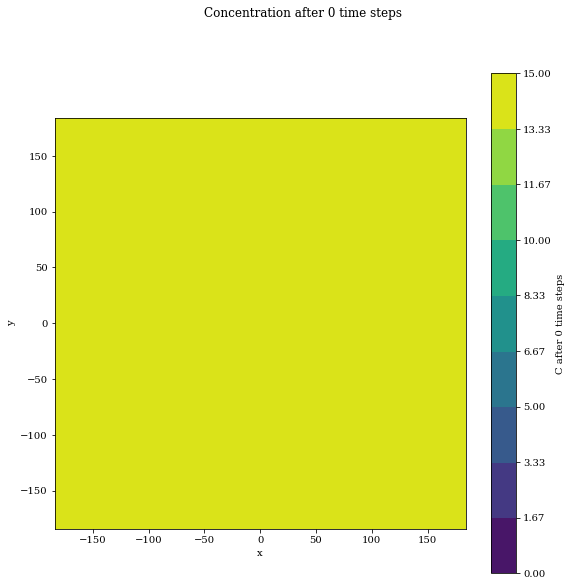

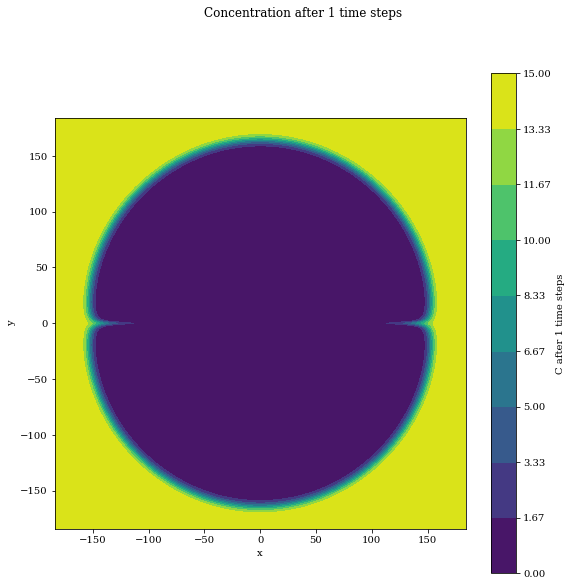

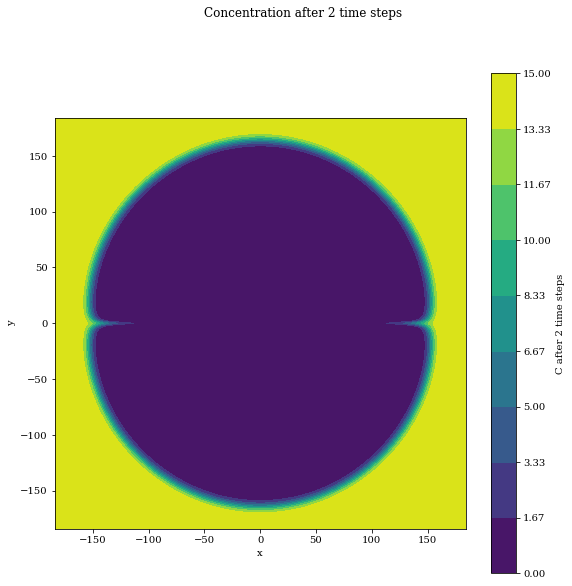

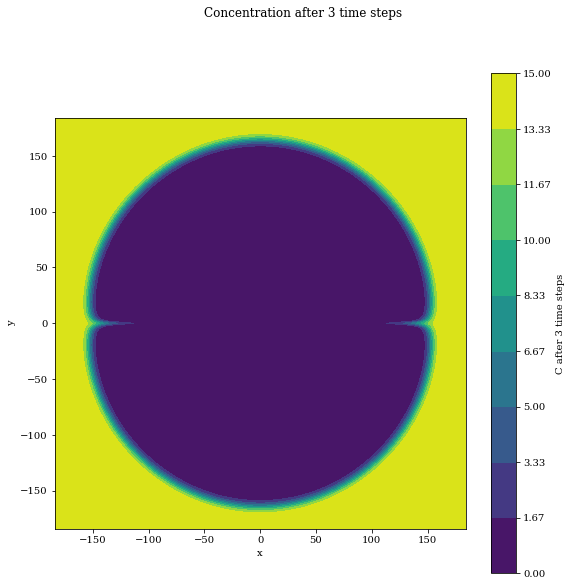

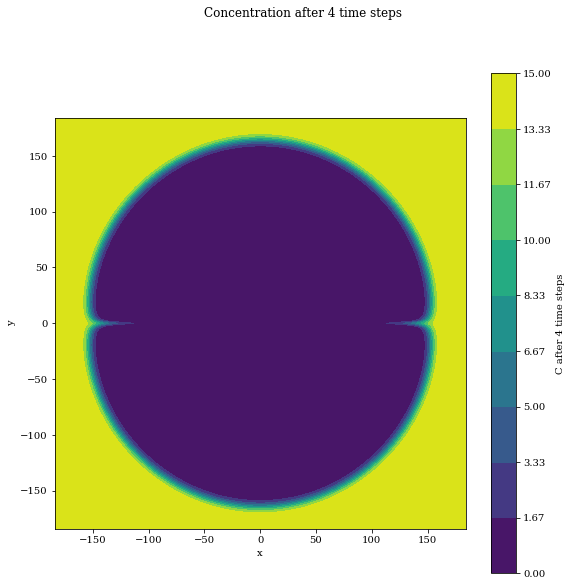

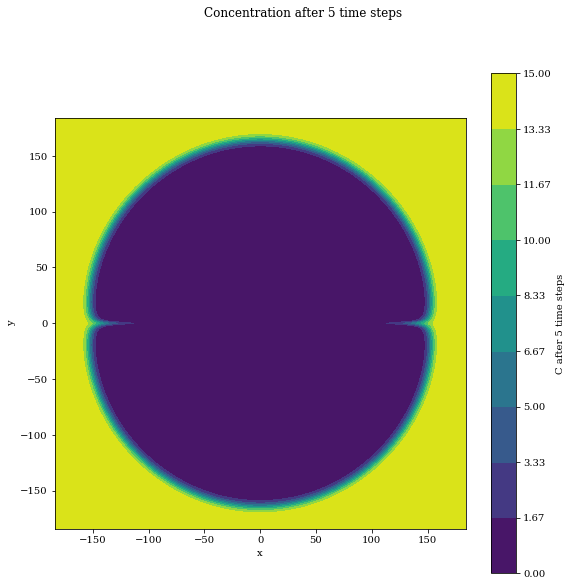

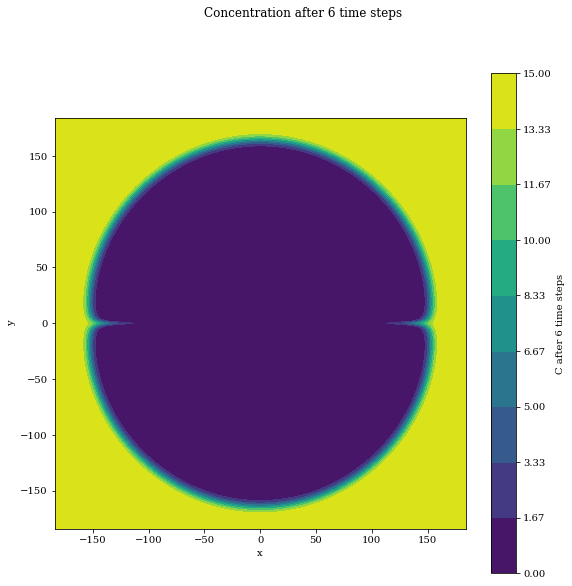

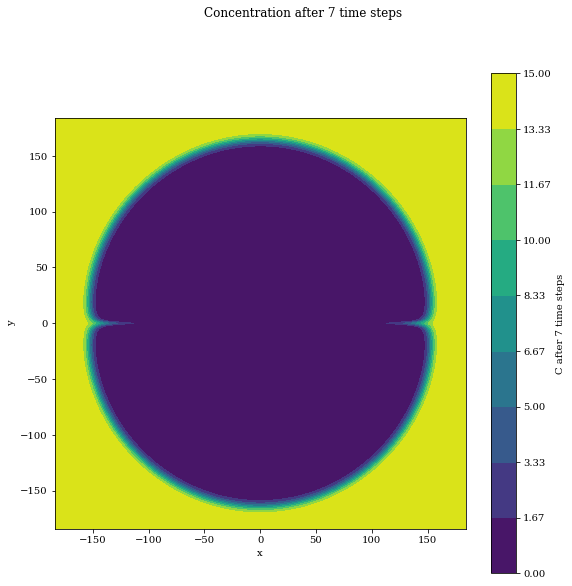

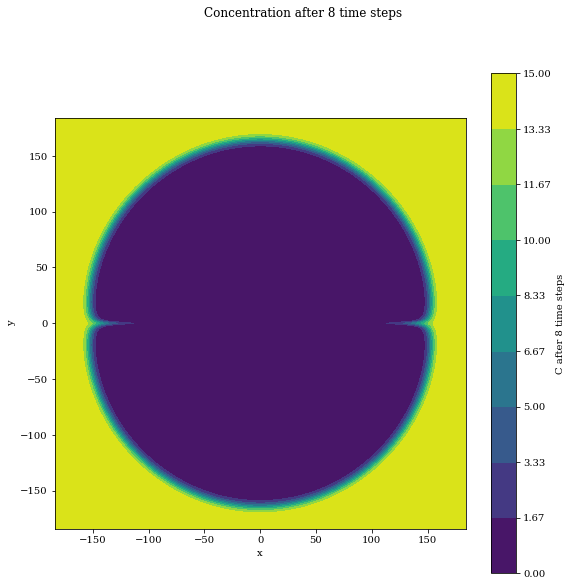

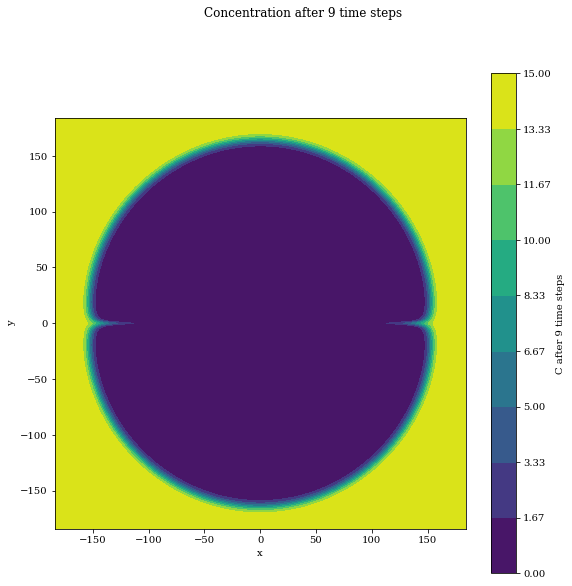

In [43]:
print("Plotting figures for Nutrient Media Concentration")
for i in range(int(nt/500)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(C_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, C_hist[i], levels=levels)
    fig.suptitle('Concentration after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('C after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

#pyplot.figure(figsize=(9.2,9.2))
#pyplot.xlabel('x')
#pyplot.ylabel('y')
#levels = np.linspace(0, 100.0, num=51)
#contf = pyplot.contourf(x, y, X2, levels=levels)
#cbar = pyplot.colorbar(contf)
#cbar.set_label('X2 after %nt steps')
#pyplot.axis('scaled', adjustable='box');

Plotting figures for X1 growth
0
1
2
3
4
5
6
7
8
9
Current time is: Sun Nov  3 14:37:30 2019


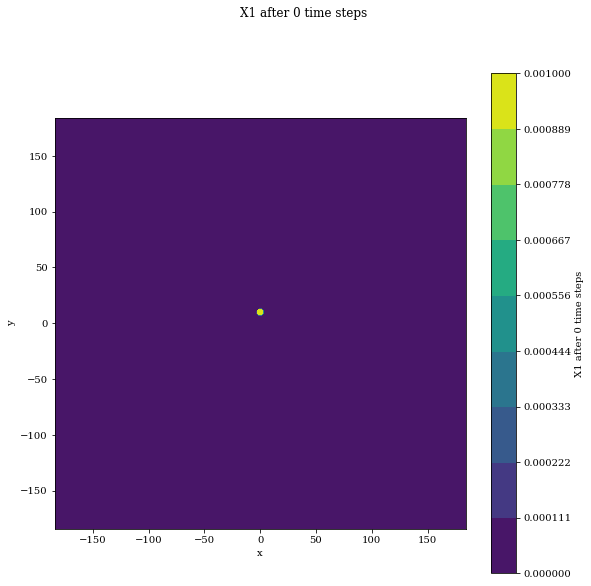

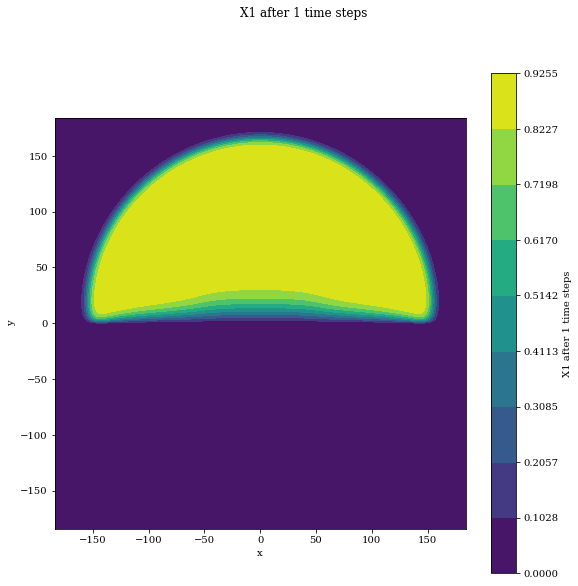

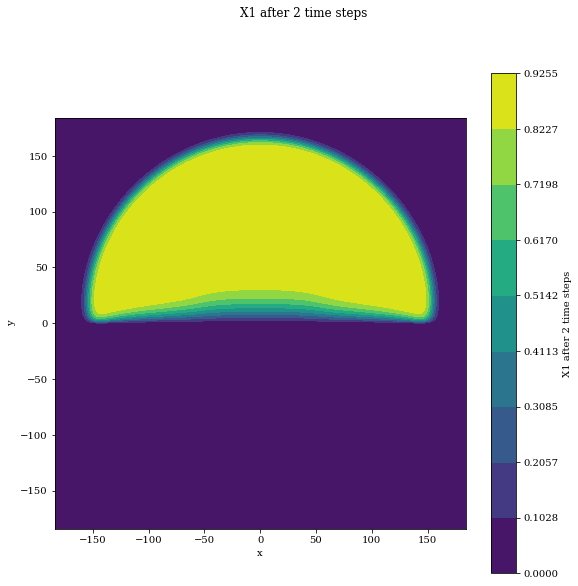

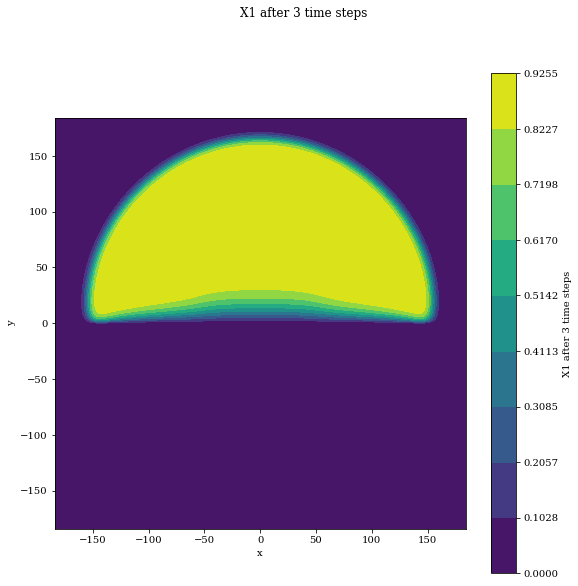

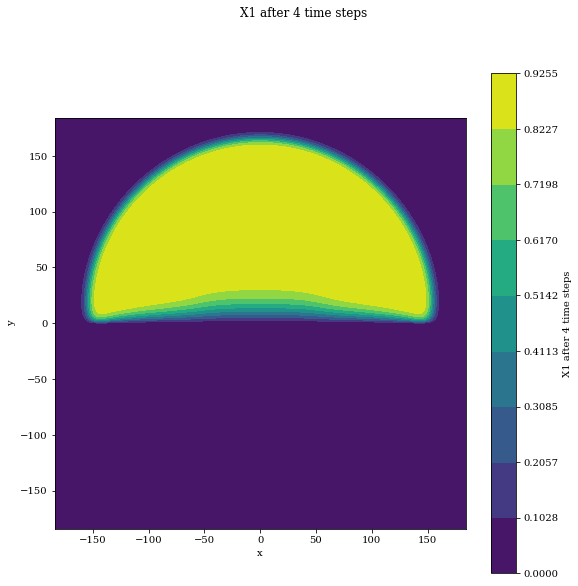

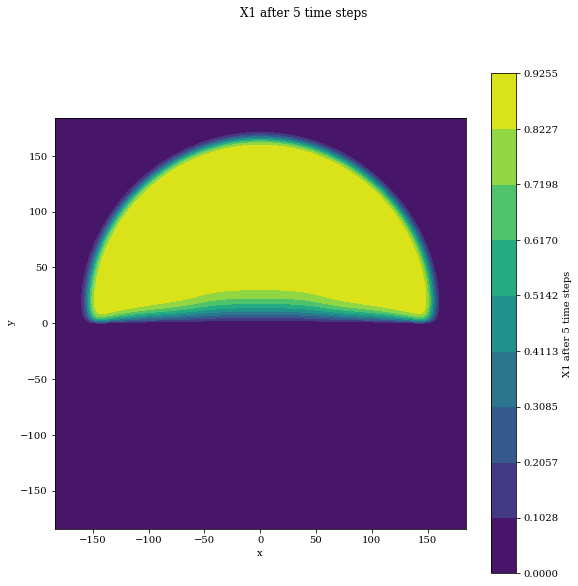

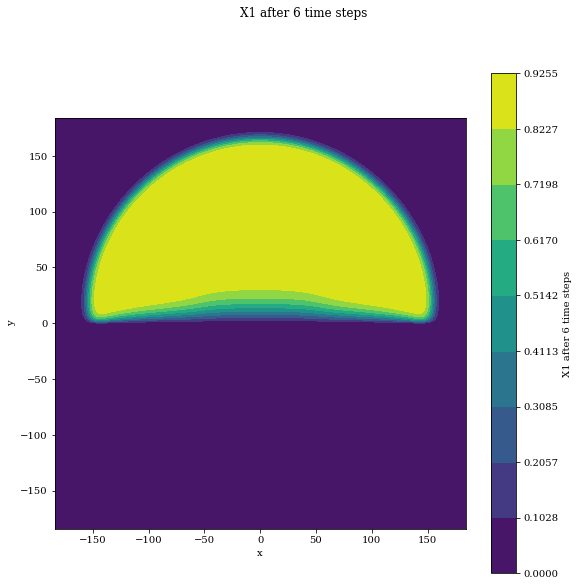

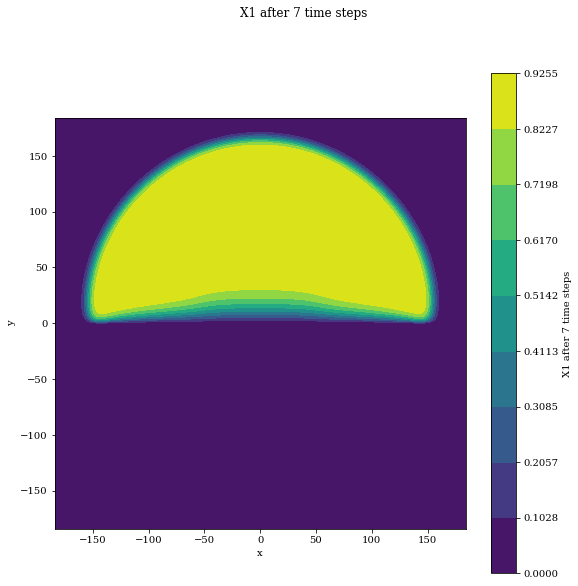

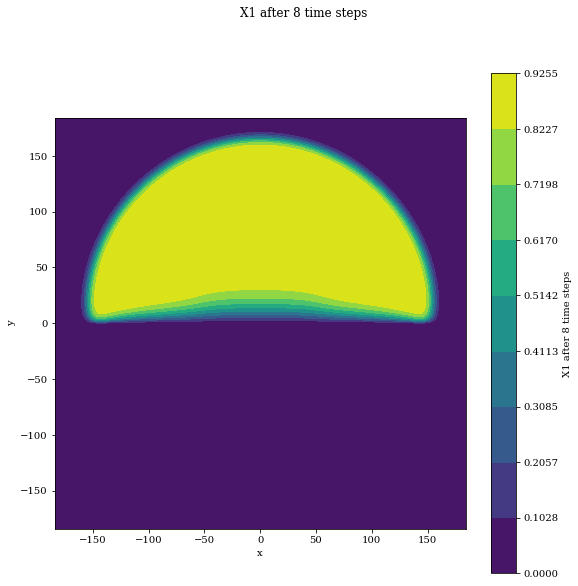

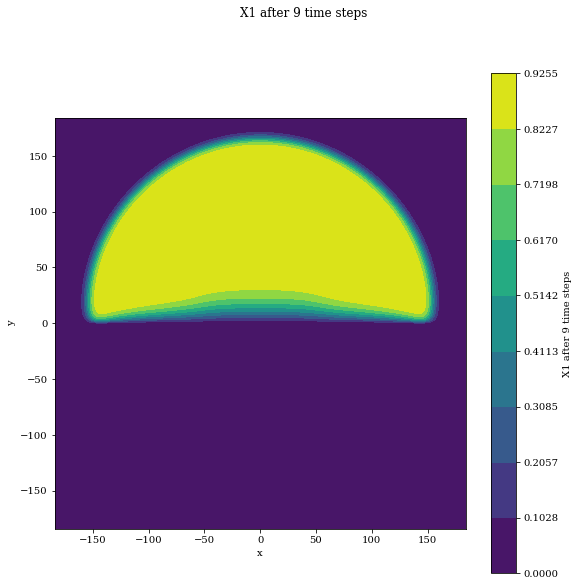

In [45]:
print("Plotting figures for X1 growth")
for i in range(int(nt/500)):
    fig=pyplot.figure(figsize=(9.2,9.2))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X1_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X1_hist[i], levels=levels)
    fig.suptitle('X1 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X1 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))


Plotting figures for X2 growth
0
1
2
3
4
5
6
7
8
9
Current time is: Sun Nov  3 14:37:54 2019


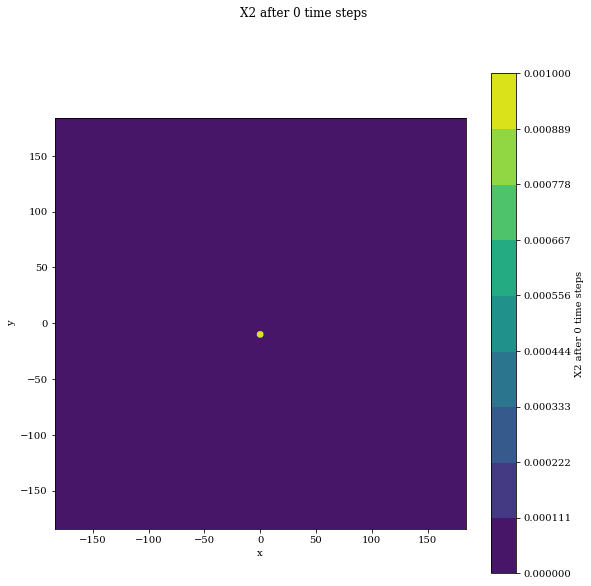

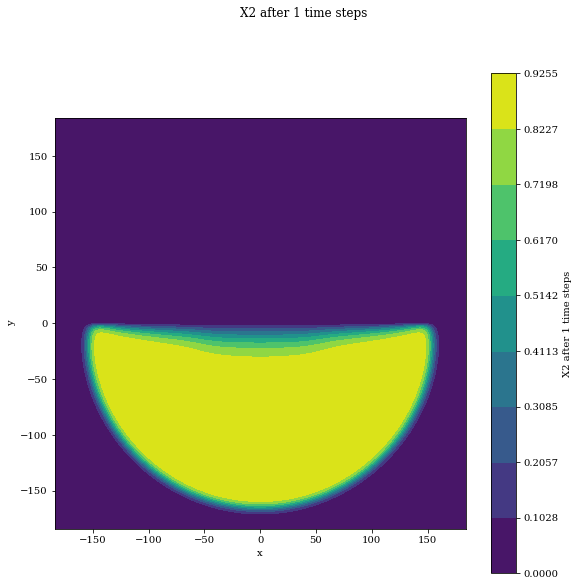

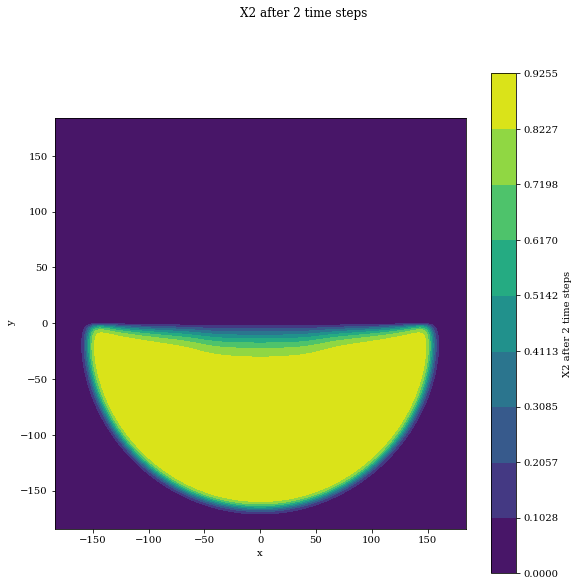

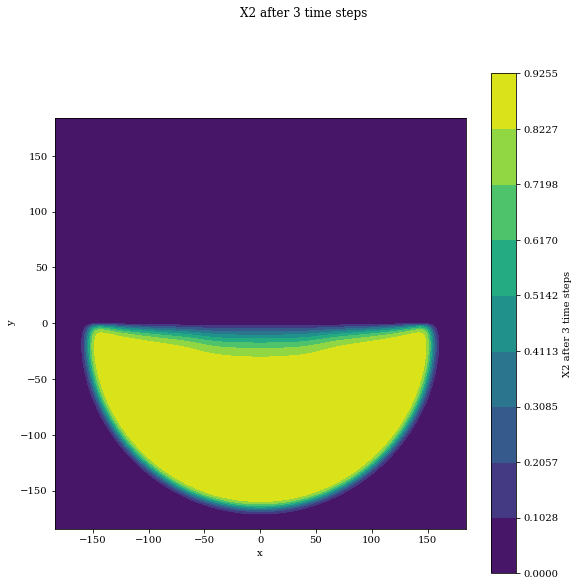

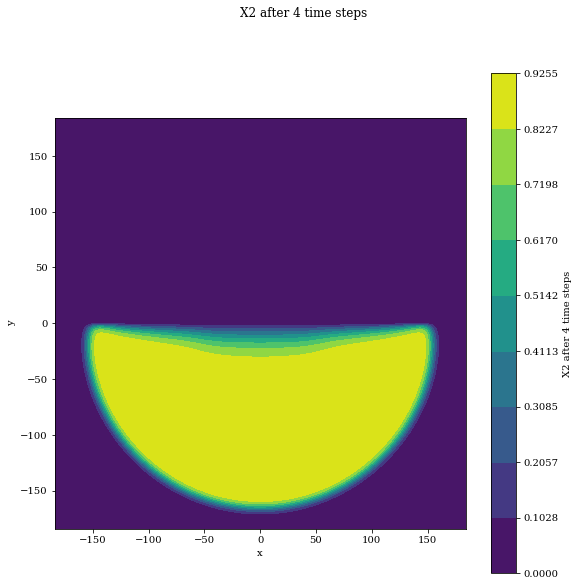

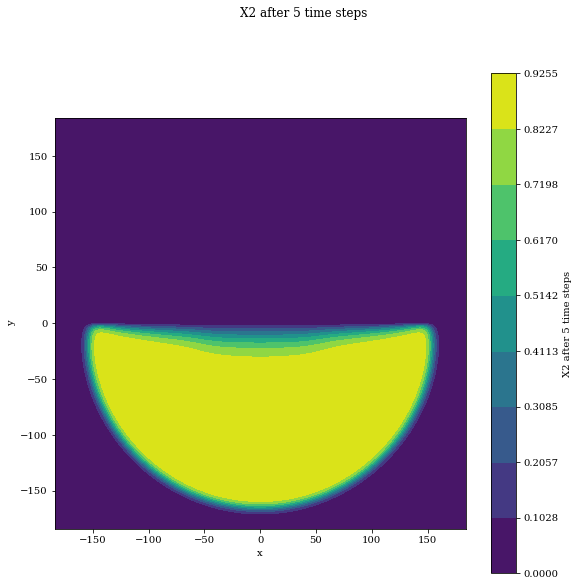

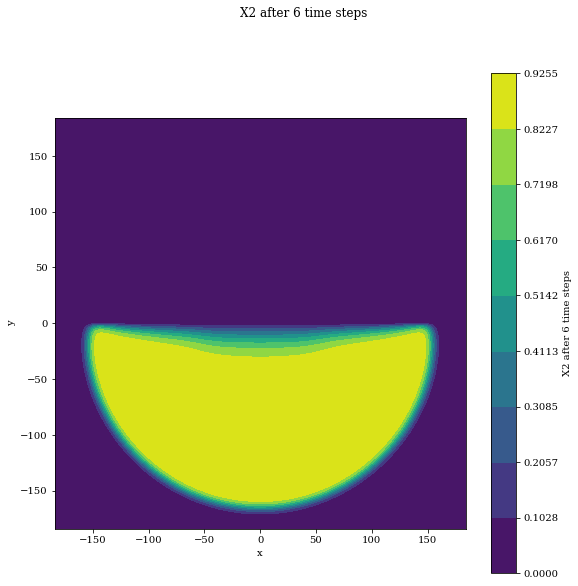

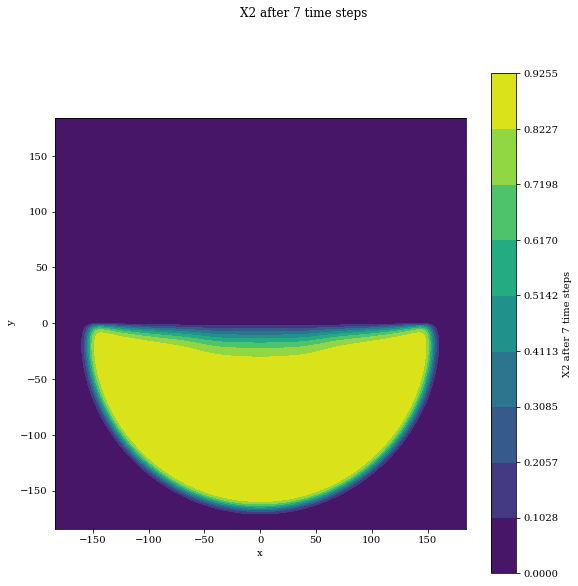

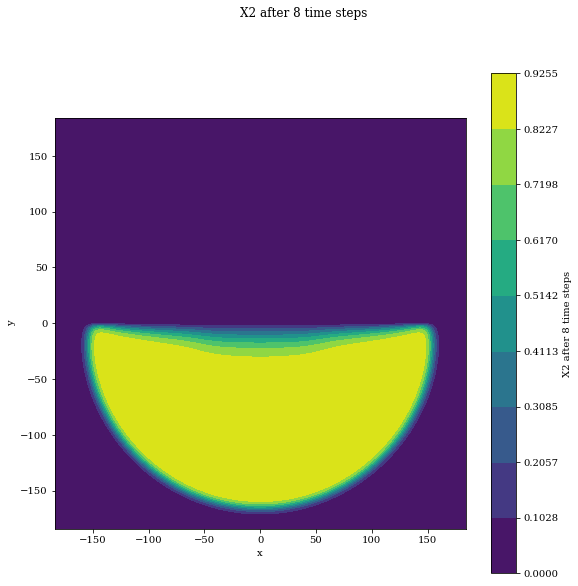

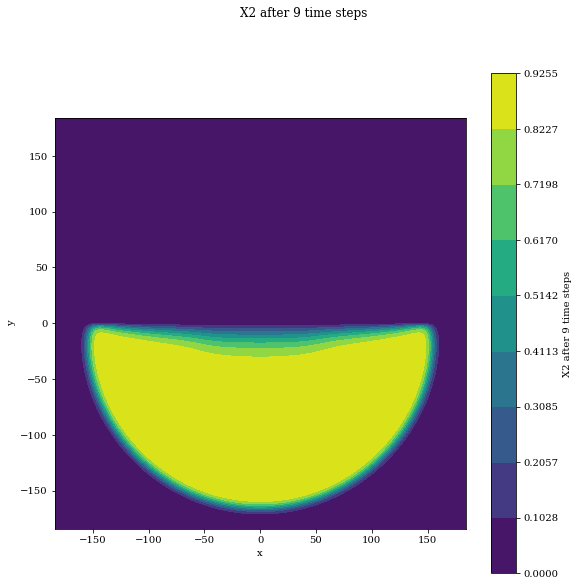

In [46]:
print("Plotting figures for X2 growth")
for i in range(int(nt/500)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    #pyplot.grid()
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X2_hist[i], levels=levels)
    fig.suptitle('X2 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X2 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

In [8]:

############# Animation ################

from matplotlib import animation
from IPython.display import HTML

In [9]:
#def update_plot(nt, C_hist):

#    """
#     Update the line y-data of the Matplotlib figure.
#     
#     Parameters
#     ----------
#     n : integer
#         The time-step index.
#     u_hist : list of numpy.ndarray objects
#         The history of the numerical solution.
#     """
#     fig.suptitle('Time step {:0>2}'.format(m))
# 
# anim = animation.FuncAnimation(fig, update_plot,
#                                frames=nt, fargs=(C_hist,),
#                                interval=300)
# 							   
# 	# Display the video.
# HTML(anim.to_html5_video())

In [10]:
import winsound
duration = 5000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

Plotting figures for X2 growth
0
1
2
3
4
5
6
7
8
9
Current time is: Sun Nov  3 14:38:24 2019


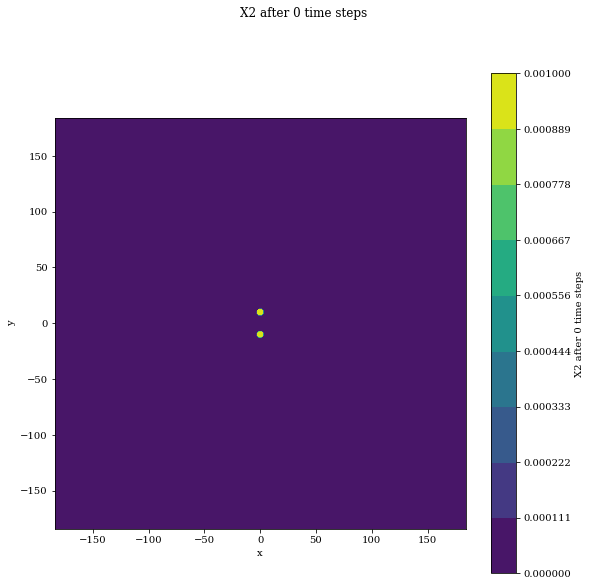

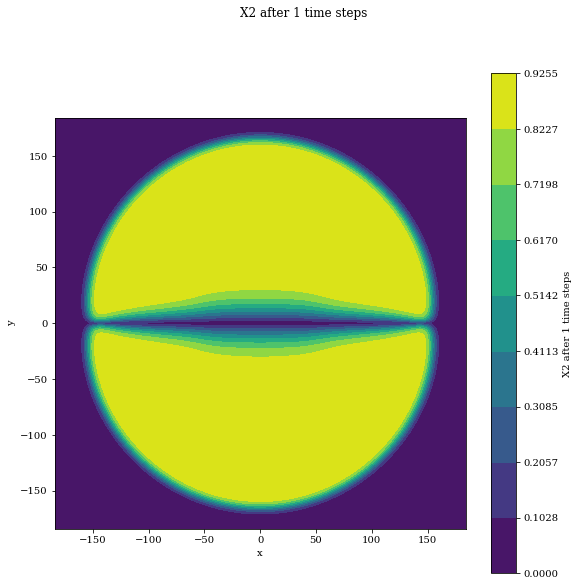

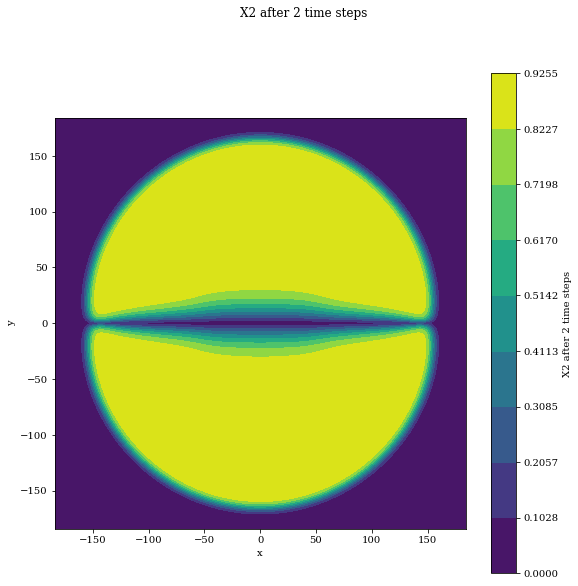

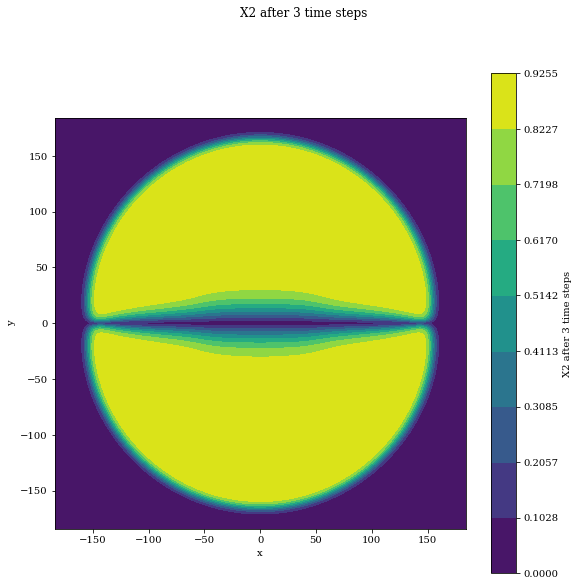

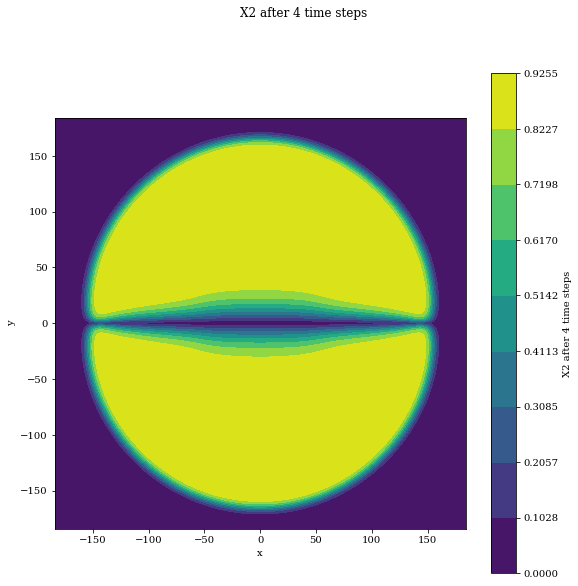

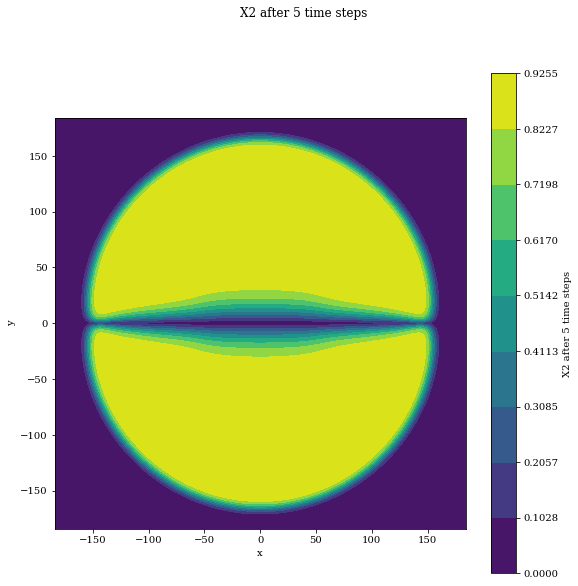

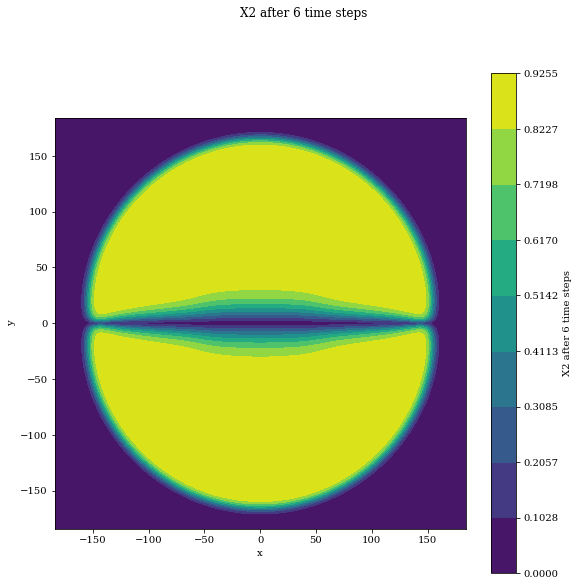

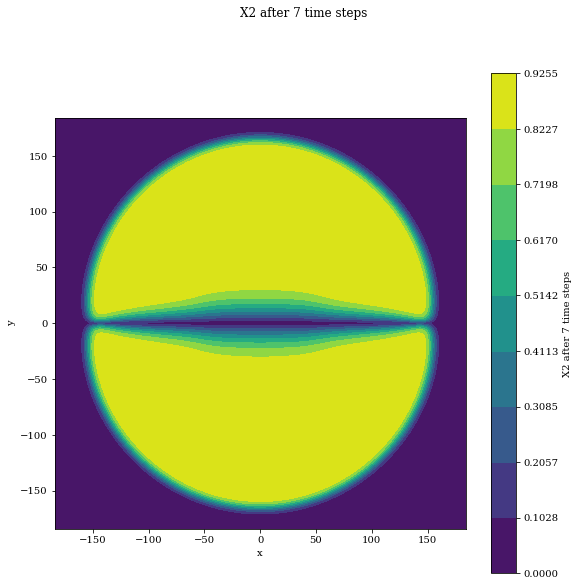

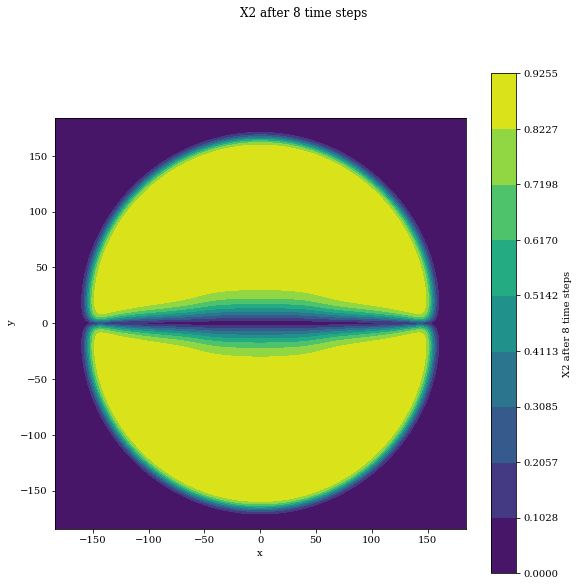

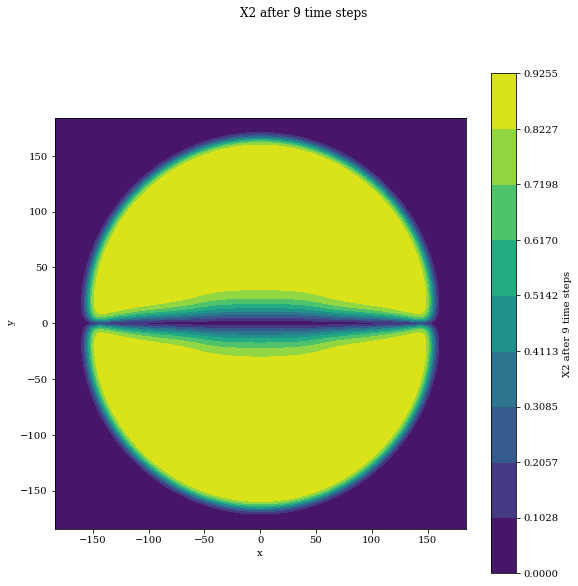

In [47]:
print("Plotting figures for X2 growth")
for i in range(int(nt/500)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    #pyplot.grid()
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X1_hist[i]+X2_hist[i], levels=levels)
    fig.suptitle('X2 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X2 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

SyntaxError: invalid syntax (<ipython-input-62-756c369f90ae>, line 1)

5002